# 1) Federated Average

### Importing necessary Libraries

In [28]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Device Configuration

In [29]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

| using device: cpu


## Data Preparation

### Loading CIPHAR10 Dataset

In [30]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the pixel values
])

In [31]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

bsz = 10

Files already downloaded and verified
Files already downloaded and verified


### Splitting Training Data

In [32]:
# Split the training data into 50 client datasets
client_datasets = torch.utils.data.random_split(train_data, [1000] * 50)

# Create a DataLoader for each client dataset
client_train_loaders = {
    str(i): torch.utils.data.DataLoader(client_datasets[i], batch_size=bsz, shuffle=True)
    for i in range(50)
}

In [33]:
# DataLoader for CIFAR-10 test set
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

## Model

### CNN Architecture

In [34]:
# Model Architecture - CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(64 * 5 * 5, 512)
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc(x))
        x = self.out(x)
        return x

In [35]:
# Initialize CNN model
cnn = CNN().to(device)
print(cnn)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=1600, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=10, bias=True)
)


In [36]:
# Training parameters
criterion = nn.CrossEntropyLoss()

In [37]:
def validate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [38]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)  # Move the local model to the same device as the input data
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for i, data in enumerate(client_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move the input data to the same device as the local model
            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return local_model

In [39]:
def running_model_avg(current, next, scale):
    if current is None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

## Federated Average Algorithm

In [40]:
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loaders, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(50), num_clients_per_round, replace=False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)  # Move the global model to the same device as the input data
        running_avg = None

        for i, c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i + 1, num_clients_per_round, c))
            local_model = train_client(c, client_train_loaders[str(c)], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1 / num_clients_per_round)

        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if t % 10 == 0:
            np.save(filename + '_{}'.format(t) + '.npy', np.array(round_accuracy))

    return np.array(round_accuracy)

## Experiment with 10 Clients per Round

In [41]:
# Run Federated Averaging experiments
acc_cnn_iid_m10 = fed_avg_experiment(cnn, num_clients_per_round=10, num_local_epochs=5, lr=0.01, client_train_loaders=client_train_loaders, max_rounds=10, filename='./acc_cnn_iid_m10')
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

starting round 0
clients:  [28 11 10 41  2 27 38 31 22  4]
round 0, starting client 1/10, id: 28
round 0, starting client 2/10, id: 11
round 0, starting client 3/10, id: 10
round 0, starting client 4/10, id: 41
round 0, starting client 5/10, id: 2
round 0, starting client 6/10, id: 27
round 0, starting client 7/10, id: 38
round 0, starting client 8/10, id: 31
round 0, starting client 9/10, id: 22
round 0, starting client 10/10, id: 4
round 0, validation acc: 0.2923
starting round 1
clients:  [ 2 30 23 16 13 28  9 45 33 37]
round 1, starting client 1/10, id: 2
round 1, starting client 2/10, id: 30
round 1, starting client 3/10, id: 23
round 1, starting client 4/10, id: 16
round 1, starting client 5/10, id: 13
round 1, starting client 6/10, id: 28
round 1, starting client 7/10, id: 9
round 1, starting client 8/10, id: 45
round 1, starting client 9/10, id: 33
round 1, starting client 10/10, id: 37
round 1, validation acc: 0.3704
starting round 2
clients:  [ 7 24 27 48 12  5 43 22 19 26]
r

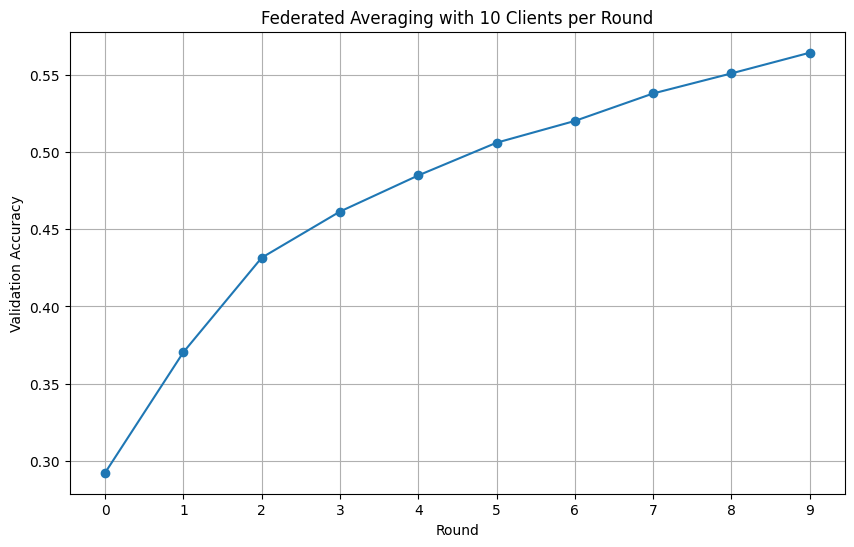

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(acc_cnn_iid_m10, marker='o', linestyle='-')
plt.title('Federated Averaging with 10 Clients per Round')
plt.xlabel('Round')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.xticks(np.arange(0, len(acc_cnn_iid_m10), step=1))
plt.show()

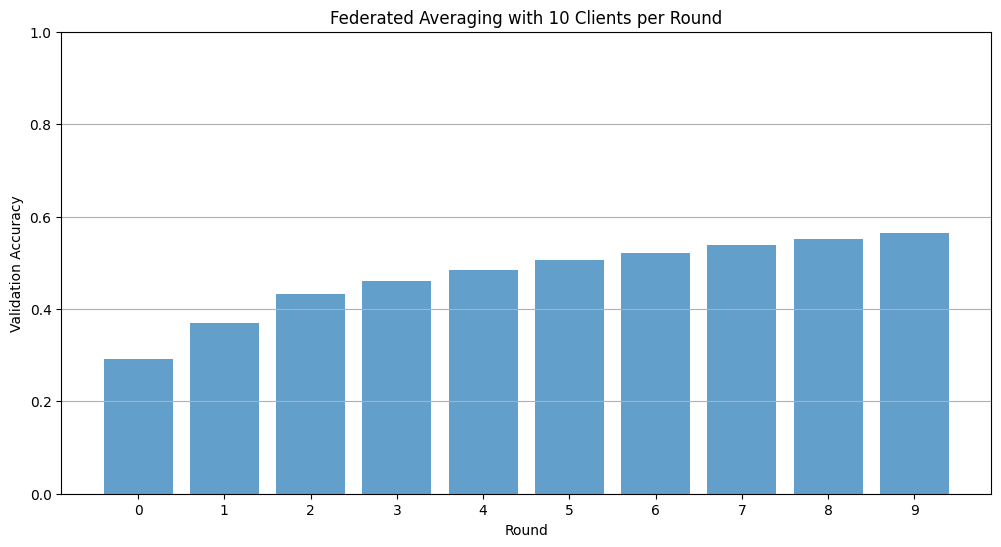

In [43]:
# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(acc_cnn_iid_m10)), acc_cnn_iid_m10, alpha=0.7)
plt.title('Federated Averaging with 10 Clients per Round')
plt.xlabel('Round')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(np.arange(0, len(acc_cnn_iid_m10), step=1))
plt.show()

# --------------------------------------------------------

# 2) Federated Personalized Learning (FedPer) 

## Model Architecture

### Global Model and Personalized Model

In [44]:
class GlobalModel(nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc = nn.Linear(64 * 5 * 5, 512)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc(x))
        return x

In [45]:
class PersonalizedModel(nn.Module):
    def __init__(self):
        super(PersonalizedModel, self).__init__()
        self.out = nn.Linear(512, 10)

    def forward(self, x):
        x = self.out(x)
        return x

### Initializing global model and personalized model

In [46]:
# Initialize global model and personalized models
global_model = GlobalModel().to(device)
personalized_models = {str(i): copy.deepcopy(PersonalizedModel().to(device)) for i in range(50)}

# Training parameters
criterion = nn.CrossEntropyLoss()

### Evaluates the models on the test set

In [47]:
def validate(global_model, personalized_models):
    global_model.eval()
    for _, personalized_model in personalized_models.items():
        personalized_model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            global_model_output = global_model(images)
            outputs = [personalized_model(global_model_output.clone()) for personalized_model in personalized_models.values()]
            outputs = torch.stack(outputs, dim=1).mean(dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

### Local Training Function

In [48]:
def train_client(id, client_loader, global_model, personalized_model, num_local_epochs, lr):
    local_global_model = copy.deepcopy(global_model)
    local_personalized_model = copy.deepcopy(personalized_model)
    local_global_model = local_global_model.to(device)
    local_personalized_model = local_personalized_model.to(device)
    local_global_model.train()
    local_personalized_model.train()
    optimizer = torch.optim.SGD([{'params': local_global_model.parameters()}, {'params': local_personalized_model.parameters()}], lr=lr)

    for epoch in range(num_local_epochs):
        for i, data in enumerate(client_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = local_global_model(inputs)
            outputs = local_personalized_model(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return local_global_model, local_personalized_model

### Running Model Average Function

In [49]:
def running_model_avg(current, next, scale):
    if current is None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

In [50]:
def fed_avg_experiment(global_model, personalized_models, num_clients_per_round, num_local_epochs, lr, client_train_loaders, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # Choose clients
        clients = np.random.choice(np.arange(50), num_clients_per_round, replace=False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i, c in enumerate(clients):
            # Train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i + 1, num_clients_per_round, c))
            local_global_model, local_personalized_model = train_client(c, client_train_loaders[str(c)], global_model, personalized_models[str(c)], num_local_epochs, lr)

            # Update global model parameters
            running_avg = running_model_avg(running_avg, local_global_model.state_dict(), 1 / num_clients_per_round)

            # Update personalized model parameters
            personalized_models[str(c)] = local_personalized_model

        # Set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # Validate
        val_acc = validate(global_model, personalized_models)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if t % 10 == 0:
            np.save(filename + '_{}'.format(t) + '.npy', np.array(round_accuracy))

    return np.array(round_accuracy)

### Personalized Experiment with 10 Clients per Round

In [51]:
acc_fedper_m10 = fed_avg_experiment(global_model, personalized_models, num_clients_per_round=10, num_local_epochs=5, lr=0.01, client_train_loaders=client_train_loaders, max_rounds=10, filename='./acc_fedper_m10')
print(acc_fedper_m10)
np.save('./acc_fedper_m10.npy', acc_fedper_m10)

starting round 0
clients:  [40 42 34 21 48 18  1 43  5 38]
round 0, starting client 1/10, id: 40
round 0, starting client 2/10, id: 42
round 0, starting client 3/10, id: 34
round 0, starting client 4/10, id: 21
round 0, starting client 5/10, id: 48
round 0, starting client 6/10, id: 18
round 0, starting client 7/10, id: 1
round 0, starting client 8/10, id: 43
round 0, starting client 9/10, id: 5
round 0, starting client 10/10, id: 38
round 0, validation acc: 0.237
starting round 1
clients:  [42 23 47 34 22  7 39 13  4  9]
round 1, starting client 1/10, id: 42
round 1, starting client 2/10, id: 23
round 1, starting client 3/10, id: 47
round 1, starting client 4/10, id: 34
round 1, starting client 5/10, id: 22
round 1, starting client 6/10, id: 7
round 1, starting client 7/10, id: 39
round 1, starting client 8/10, id: 13
round 1, starting client 9/10, id: 4
round 1, starting client 10/10, id: 9
round 1, validation acc: 0.2955
starting round 2
clients:  [40 36  9 11  2 24  0 31 39 20]
rou

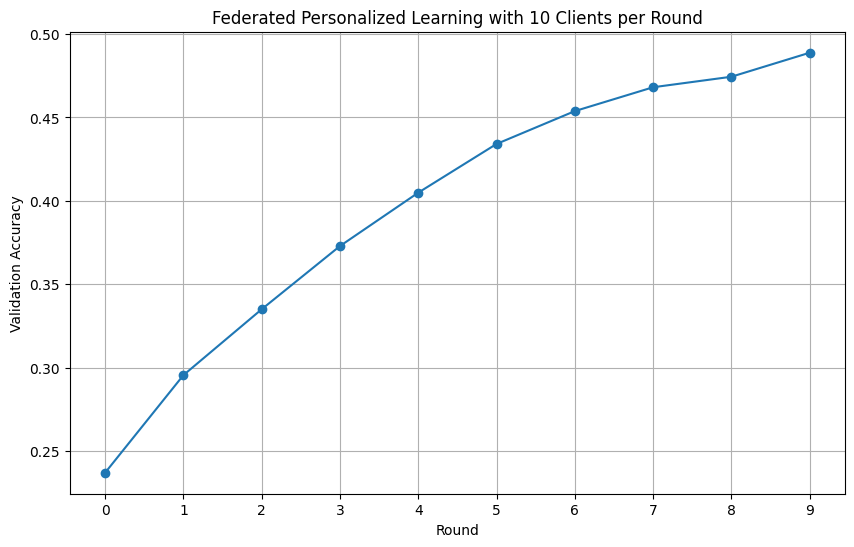

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(acc_fedper_m10, marker='o', linestyle='-')
plt.title('Federated Personalized Learning with 10 Clients per Round')
plt.xlabel('Round')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.xticks(np.arange(0, len(acc_fedper_m10), step=1))
plt.show()

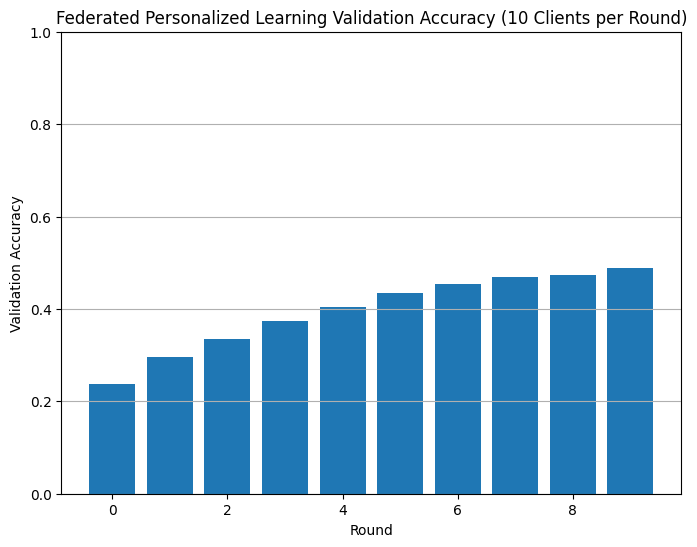

In [53]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(acc_fedper_m10)), acc_fedper_m10)
plt.xlabel('Round')
plt.ylabel('Validation Accuracy')
plt.title('Federated Personalized Learning Validation Accuracy (10 Clients per Round)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Federated Momentum Averaging (FedAvgM)

### Validation Function


In [14]:
def validate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

### Local Training Function

In [15]:
def train_client(id, client_loader, global_model, num_local_epochs, lr, momentum):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(num_local_epochs):
        for i, data in enumerate(client_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    return local_model

### Running Model Average Function

In [16]:
def running_model_avg(current, next, scale):
    if current is None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

In [17]:
def fed_avgm_experiment(global_model, num_clients_per_round, num_local_epochs, lr, momentum, client_train_loaders, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print(f"starting round {t}")
        clients = np.random.choice(np.arange(50), num_clients_per_round, replace=False)
        print(f"clients: {clients}")

        global_model.eval()
        global_model = global_model.to(device)
        running_avg = None

        for i, c in enumerate(clients):
            print(f"round {t}, starting client {i+1}/{num_clients_per_round}, id: {c}")
            local_model = train_client(c, client_train_loaders[str(c)], global_model, num_local_epochs, lr, momentum)
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1 / num_clients_per_round)

        global_model.load_state_dict(running_avg)
        val_acc = validate(global_model)
        print(f"round {t}, validation acc: {val_acc:.4f}")
        round_accuracy.append(val_acc)

        if t % 10 == 0:
            np.save(filename + f'_{t}.npy', np.array(round_accuracy))

    return np.array(round_accuracy)

## Experiment with 10 Clients per Round

In [18]:
acc_fedavgm_m10 = fed_avgm_experiment(cnn, num_clients_per_round=10, num_local_epochs=5, lr=0.01, momentum=0.9, client_train_loaders=client_train_loaders, max_rounds=10, filename='./acc_fedavgm_m10')
print(acc_fedavgm_m10)
np.save('./acc_fedavgm_m10.npy', acc_fedavgm_m10)

starting round 0
clients: [28 11 10 41  2 27 38 31 22  4]
round 0, starting client 1/10, id: 28
round 0, starting client 2/10, id: 11
round 0, starting client 3/10, id: 10
round 0, starting client 4/10, id: 41
round 0, starting client 5/10, id: 2
round 0, starting client 6/10, id: 27
round 0, starting client 7/10, id: 38
round 0, starting client 8/10, id: 31
round 0, starting client 9/10, id: 22
round 0, starting client 10/10, id: 4
round 0, validation acc: 0.4239
starting round 1
clients: [ 2 30 23 16 13 28  9 45 33 37]
round 1, starting client 1/10, id: 2
round 1, starting client 2/10, id: 30
round 1, starting client 3/10, id: 23
round 1, starting client 4/10, id: 16
round 1, starting client 5/10, id: 13
round 1, starting client 6/10, id: 28
round 1, starting client 7/10, id: 9
round 1, starting client 8/10, id: 45
round 1, starting client 9/10, id: 33
round 1, starting client 10/10, id: 37
round 1, validation acc: 0.4876
starting round 2
clients: [ 7 24 27 48 12  5 43 22 19 26]
roun

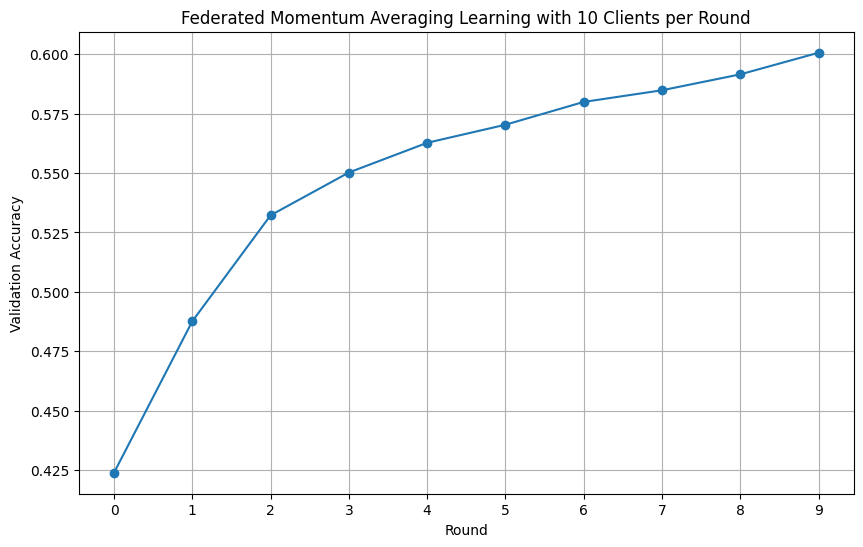

In [23]:


plt.figure(figsize=(10, 6))
plt.plot(acc_fedavgm_m10, marker='o', linestyle='-')
plt.title('Federated Momentum Averaging Learning with 10 Clients per Round')
plt.xlabel('Round')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.xticks(np.arange(0, len(acc_fedavgm_m10), step=1))
plt.show()

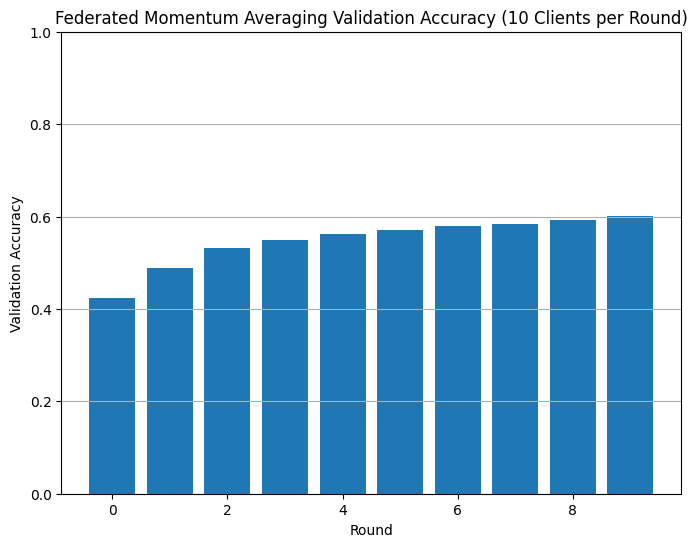

In [24]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(acc_fedavgm_m10)),acc_fedavgm_m10)
plt.xlabel('Round')
plt.ylabel('Validation Accuracy')
plt.title('Federated Momentum Averaging Validation Accuracy (10 Clients per Round)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Comparision

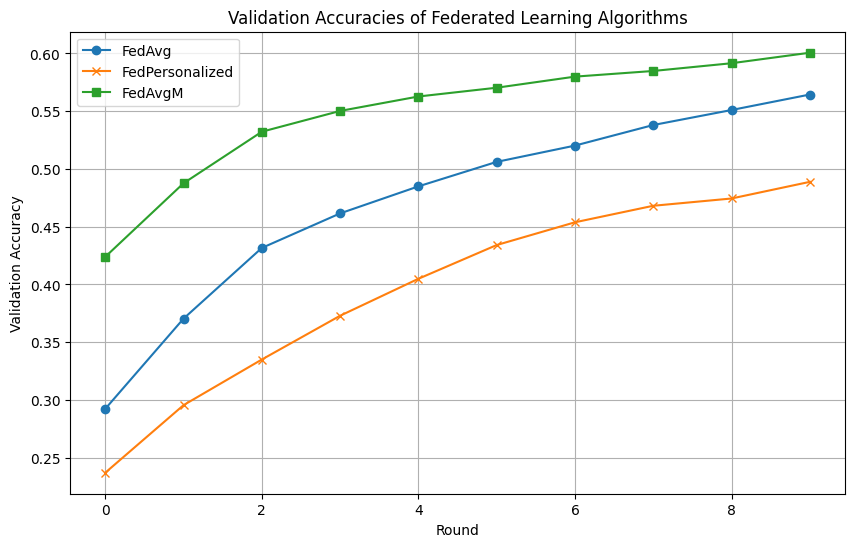

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(acc_cnn_iid_m10, label='FedAvg', marker='o')
plt.plot(acc_fedper_m10, label='FedPersonalized', marker='x')
plt.plot(acc_fedavgm_m10, label='FedAvgM', marker='s')
plt.title('Validation Accuracies of Federated Learning Algorithms')
plt.xlabel('Round')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()